# Flip 7 Championship Meta-Analysis

This notebook analyzes results across multiple championship tournaments to identify consistently high-performing strategies. Each player receives points based on their ranking in each championship, and we compute aggregate scores to determine overall winners.

## 1. Import Required Libraries

In [1]:
import json
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

print("✅ All libraries imported successfully!")
print(f"Meta-analysis start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
Meta-analysis start time: 2026-01-20 15:31:25


## 2. Configuration and Scoring System

Define the scoring system for ranking positions. Higher rankings receive more points.

In [2]:
# Meta-analysis configuration
RESULTS_DIRECTORY = '../results/'
NUM_CHAMPIONSHIPS = 10

# Scoring system: Points awarded based on ranking
# Option 1: Inverse ranking (1st place gets max points)
def calculate_rank_score(rank, total_players):
    """Calculate score based on ranking position (inverse ranking system)."""
    return total_players - rank + 1

# Option 2: Percentile-based scoring
def calculate_percentile_score(rank, total_players):
    """Calculate percentile score (0-100) based on ranking."""
    return 100 * (total_players - rank) / total_players

# Choose scoring method
SCORING_METHOD = 'inverse'  # 'inverse' or 'percentile'

print(f"📊 Meta-Analysis Configuration:")
print(f"   Results directory: {RESULTS_DIRECTORY}")
print(f"   Number of championships: {NUM_CHAMPIONSHIPS}")
print(f"   Scoring method: {SCORING_METHOD}")

📊 Meta-Analysis Configuration:
   Results directory: ../results/
   Number of championships: 10
   Scoring method: inverse


## 3. Load Championship Results

Load result files from multiple championship tournaments.

In [3]:
# Get all championship result files
result_files = sorted(glob.glob(os.path.join(RESULTS_DIRECTORY, 'championship_results_*.json')))

print(f"🔍 Found {len(result_files)} championship result files:")
for i, file in enumerate(result_files[-NUM_CHAMPIONSHIPS:], 1):
    filename = os.path.basename(file)
    print(f"   {i}. {filename}")

# Use the most recent NUM_CHAMPIONSHIPS files
selected_files = result_files[-NUM_CHAMPIONSHIPS:]

if len(selected_files) < NUM_CHAMPIONSHIPS:
    print(f"\n⚠️ Warning: Only {len(selected_files)} championship files available (requested {NUM_CHAMPIONSHIPS})")
    NUM_CHAMPIONSHIPS = len(selected_files)
else:
    print(f"\n✅ Using the {NUM_CHAMPIONSHIPS} most recent championship results")

🔍 Found 10 championship result files:
   1. championship_results_20260119_163208.json
   2. championship_results_20260120_121409.json
   3. championship_results_20260120_125822.json
   4. championship_results_20260120_131741.json
   5. championship_results_20260120_133626.json
   6. championship_results_20260120_135251.json
   7. championship_results_20260120_141618.json
   8. championship_results_20260120_143832.json
   9. championship_results_20260120_145613.json
   10. championship_results_20260120_152512.json

✅ Using the 10 most recent championship results


## 4. Parse and Extract Rankings

Extract player rankings from each championship and assign scores.

In [4]:
# Store all championship data
championships_data = []
all_player_names = set()

for idx, file_path in enumerate(selected_files, 1):
    print(f"📖 Loading Championship {idx}...")
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract rankings
    rankings = data['leaderboard']['rankings']
    total_players = len(rankings)
    
    # Create DataFrame for this championship
    df_champ = pd.DataFrame(rankings)
    
    # Calculate scores based on ranking
    if SCORING_METHOD == 'inverse':
        df_champ['meta_score'] = df_champ['rank'].apply(lambda r: calculate_rank_score(r, total_players))
    else:  # percentile
        df_champ['meta_score'] = df_champ['rank'].apply(lambda r: calculate_percentile_score(r, total_players))
    
    df_champ['championship_id'] = idx
    championships_data.append(df_champ)
    
    # Track all unique player names
    all_player_names.update(df_champ['name'].tolist())
    
    # Display champion of this championship
    champion = df_champ.iloc[0]
    print(f"   Champion: {champion['name']} (Rank 1, Score: {champion['meta_score']:.1f})")

print(f"\n✅ Loaded {len(championships_data)} championships")
print(f"📊 Total unique players: {len(all_player_names)}")

📖 Loading Championship 1...
   Champion: Player_21_Single:_High_|_Conservative_High_Value_3 (Rank 1, Score: 575.0)
📖 Loading Championship 2...
   Champion: Player_512_ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Conservative_Hand_Size_+_Moderate_High_Value_3 (Rank 1, Score: 575.0)
📖 Loading Championship 3...
   Champion: Player_178_TwoClass:_Hand+High_|_Very_Conservative_Hand_Size_+_Aggressive_High_Value_2 (Rank 1, Score: 575.0)
📖 Loading Championship 4...
   Champion: Player_542_ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Aggressive_Hand_Size_+_Moderate_High_Value_3 (Rank 1, Score: 575.0)
📖 Loading Championship 5...
   Champion: Player_07_Single:_Hand_|_Moderate_Hand_Size (Rank 1, Score: 575.0)
📖 Loading Championship 6...
   Champion: Player_22_Single:_High_|_Moderate_High_Value_3 (Rank 1, Score: 575.0)
📖 Loading Championship 7...
   Champion: Player_125_TwoClass:_Score+High_|_Very_Aggressive_Score_+_Very_Aggressive_High_Value_3 (Rank 1, Score: 575.0)
📖 Loading Cham

## 5. Aggregate Scores Across Championships

Calculate total meta-scores for each player across all championships.

In [5]:
# Combine all championship data
df_all = pd.concat(championships_data, ignore_index=True)

# Calculate aggregate statistics for each player
player_stats = df_all.groupby('name').agg({
    'meta_score': ['sum', 'mean', 'std', 'min', 'max'],
    'rank': ['mean', 'std', 'min', 'max'],
    'wins': ['sum', 'mean'],
    'win_percentage': 'mean',
    'average_score': 'mean',
    'championship_id': 'count'
}).round(2)

# Flatten column names
player_stats.columns = ['_'.join(col).strip() for col in player_stats.columns.values]
player_stats.rename(columns={'championship_id_count': 'championships_played'}, inplace=True)

# Sort by total meta score
player_stats = player_stats.sort_values('meta_score_sum', ascending=False)
player_stats['meta_rank'] = range(1, len(player_stats) + 1)

# Extract strategy name from player name
player_stats['strategy'] = player_stats.index.map(lambda x: df_all[df_all['name'] == x]['strategy'].iloc[0])

print("📊 META-ANALYSIS AGGREGATE STATISTICS")
print("="*60)
print(f"Total players analyzed: {len(player_stats)}")
print(f"Championships included: {NUM_CHAMPIONSHIPS}")
print(f"Total games analyzed: {df_all['games_played'].sum()}")

# Display top 10 performers
print("\n🏆 TOP 10 OVERALL PERFORMERS (Across All Championships):")
print("="*60)
display_cols = ['meta_rank', 'meta_score_sum', 'meta_score_mean', 'rank_mean', 'rank_std', 'strategy']
print(player_stats[display_cols].head(10).to_string())

📊 META-ANALYSIS AGGREGATE STATISTICS
Total players analyzed: 575
Championships included: 10
Total games analyzed: 57500000

🏆 TOP 10 OVERALL PERFORMERS (Across All Championships):
                                                                                                                        meta_rank  meta_score_sum  meta_score_mean  rank_mean  rank_std                                                                                                     strategy
name                                                                                                                                                                                                                                                                                                
Player_527_ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Moderate_Hand_Size_+_Moderate_High_Value_3                     1            4969            496.9       79.1     76.30             ThreeClass: Score+Hand+High | Very Agg

## 6. Podium Analysis

Detailed analysis of the top 3 overall performers.

In [6]:
print("🥇 META-CHAMPIONSHIP PODIUM")
print("="*60)

for position in range(3):
    player_name = player_stats.index[position]
    stats = player_stats.iloc[position]
    
    medals = ['🥇', '🥈', '🥉']
    print(f"\n{medals[position]} {position + 1}ST PLACE: {player_name.split('_', 2)[-1]}")
    print(f"   Strategy: {stats['strategy']}")
    print(f"   Total Meta Score: {stats['meta_score_sum']:.1f}")
    print(f"   Average Meta Score: {stats['meta_score_mean']:.1f} ± {stats['meta_score_std']:.1f}")
    print(f"   Average Ranking: {stats['rank_mean']:.1f} (Best: {int(stats['rank_min'])}, Worst: {int(stats['rank_max'])})")
    print(f"   Ranking Consistency (Std Dev): {stats['rank_std']:.1f}")
    print(f"   Average Win %: {stats['win_percentage_mean']:.2f}%")
    print(f"   Total Wins: {int(stats['wins_sum'])}")
    
    # Get individual championship rankings for this player
    player_history = df_all[df_all['name'] == player_name][['championship_id', 'rank', 'meta_score']].sort_values('championship_id')
    ranks_str = ', '.join([f"C{row['championship_id']}:#{int(row['rank'])}" for _, row in player_history.iterrows()])
    print(f"   Championship Rankings: {ranks_str}")

🥇 META-CHAMPIONSHIP PODIUM

🥇 1ST PLACE: ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Moderate_Hand_Size_+_Moderate_High_Value_3
   Strategy: ThreeClass: Score+Hand+High | Very Aggressive Score + Moderate Hand Size + Moderate High Value_3
   Total Meta Score: 4969.0
   Average Meta Score: 496.9 ± 76.3
   Average Ranking: 79.1 (Best: 3, Worst: 220)
   Ranking Consistency (Std Dev): 76.3
   Average Win %: 69.17%
   Total Wins: 69166
   Championship Rankings: C1:#199, C2:#83, C3:#29, C4:#68, C5:#97, C6:#3, C7:#220, C8:#16, C9:#70, C10:#6

🥈 2ST PLACE: TwoClass:_Score+Hand_|_High_Score_+_Aggressive_Hand_Size
   Strategy: TwoClass: Score+Hand | High Score + Aggressive Hand Size
   Total Meta Score: 4949.0
   Average Meta Score: 494.9 ± 46.5
   Average Ranking: 81.1 (Best: 17, Worst: 184)
   Ranking Consistency (Std Dev): 46.5
   Average Win %: 78.33%
   Total Wins: 78328
   Championship Rankings: C1:#98, C2:#184, C3:#41, C4:#64, C5:#87, C6:#122, C7:#55, C8:#69, C9:#17, C10:#74

🥉 3

## 7. Consistency Analysis

Identify players with the most consistent performance across championships.

In [7]:
# Most consistent performers (lowest standard deviation in ranking)
consistent_players = player_stats.sort_values('rank_std').head(10)

print("📈 MOST CONSISTENT PERFORMERS (Lowest Ranking Variance)")
print("="*60)
display_cols = ['rank_mean', 'rank_std', 'rank_min', 'rank_max', 'meta_score_sum', 'strategy']
print(consistent_players[display_cols].to_string())

# Identify "dark horses" - players with high variance who sometimes excel
volatile_players = player_stats.sort_values('rank_std', ascending=False).head(10)

print("\n🎲 MOST VOLATILE PERFORMERS (Highest Ranking Variance)")
print("="*60)
print(volatile_players[display_cols].to_string())

📈 MOST CONSISTENT PERFORMERS (Lowest Ranking Variance)
                                                                                                                   rank_mean  rank_std  rank_min  rank_max  meta_score_sum                                                                                                strategy
name                                                                                                                                                                                                                                                                              
Player_444_ThreeClass:_Score+Hand+High_|_High_Score_+_Moderate_Hand_Size_+_Strict_High_Value                           523.8     28.71       481       559             522                       ThreeClass: Score+Hand+High | High Score + Moderate Hand Size + Strict High Value
Player_384_ThreeClass:_Score+Hand+High_|_Aggressive_Score_+_Aggressive_Hand_Size_+_Strict_High_Value                   5

## 8. Strategy Performance Analysis

Analyze which strategy types perform best on average.

In [8]:
# Aggregate by strategy type
strategy_performance = player_stats.groupby('strategy').agg({
    'meta_score_sum': 'mean',
    'rank_mean': 'mean',
    'rank_std': 'mean',
    'win_percentage_mean': 'mean',
    'meta_rank': 'count'
}).round(2)

strategy_performance.rename(columns={'meta_rank': 'num_players'}, inplace=True)
strategy_performance = strategy_performance.sort_values('meta_score_sum', ascending=False)

print("🎯 STRATEGY TYPE PERFORMANCE (Top 15)")
print("="*60)
print(strategy_performance.head(15).to_string())

# Best overall strategy
best_strategy = strategy_performance.index[0]
best_stats = strategy_performance.iloc[0]
print(f"\n⭐ Best Overall Strategy: {best_strategy}")
print(f"   Average Meta Score: {best_stats['meta_score_sum']:.1f}")
print(f"   Average Ranking: {best_stats['rank_mean']:.1f}")
print(f"   Average Win %: {best_stats['win_percentage_mean']:.2f}%")

🎯 STRATEGY TYPE PERFORMANCE (Top 15)
                                                                                                             meta_score_sum  rank_mean  rank_std  win_percentage_mean  num_players
strategy                                                                                                                                                                          
ThreeClass: Score+Hand+High | Very Aggressive Score + Moderate Hand Size + Moderate High Value_3                     4969.0       79.1     76.30                69.17            1
TwoClass: Score+Hand | High Score + Aggressive Hand Size                                                             4949.0       81.1     46.51                78.33            1
ThreeClass: Score+Hand+High | High Score + Very Aggressive Hand Size + Very Aggressive High Value_3                  4926.0       83.4     72.74                65.83            1
ThreeClass: Score+Hand+High | High Score + Moderate Hand Size + Aggr

## 9. Visualization: Meta Score Distribution

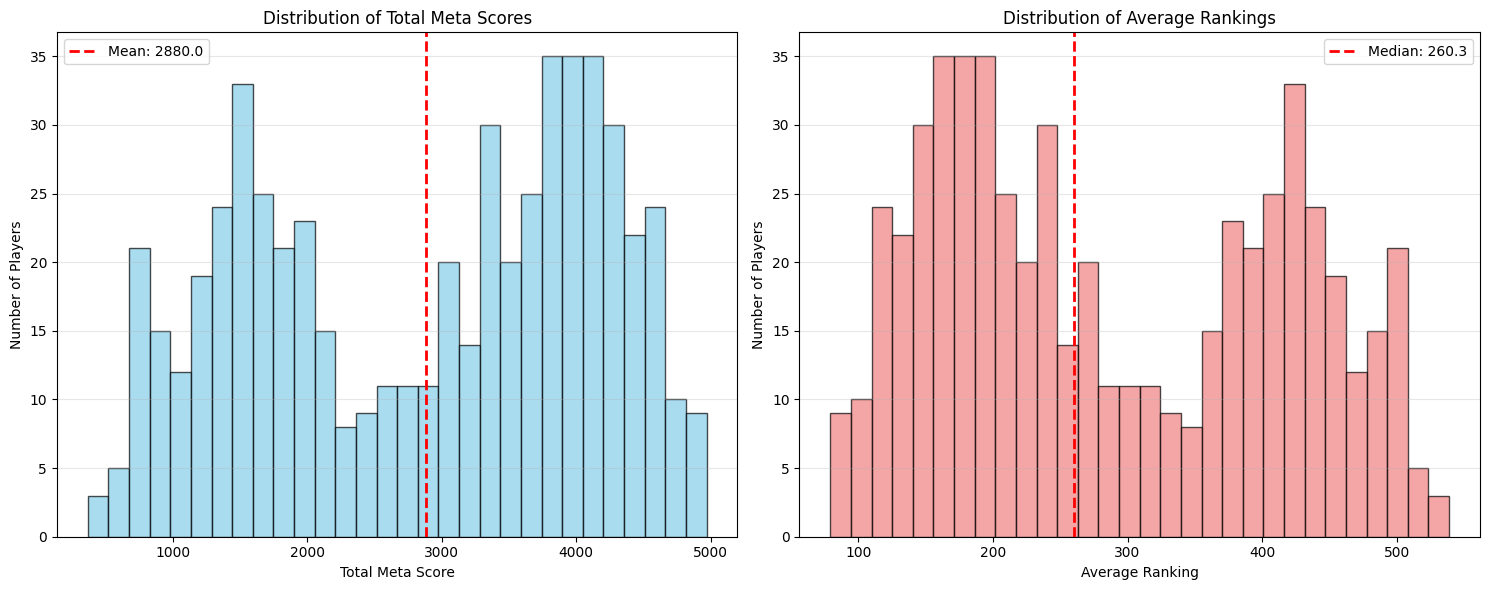

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Total meta scores distribution
ax1.hist(player_stats['meta_score_sum'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(x=player_stats['meta_score_sum'].mean(), color='red', linestyle='--', linewidth=2,
           label=f"Mean: {player_stats['meta_score_sum'].mean():.1f}")
ax1.set_xlabel('Total Meta Score')
ax1.set_ylabel('Number of Players')
ax1.set_title('Distribution of Total Meta Scores')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Average ranking distribution
ax2.hist(player_stats['rank_mean'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.axvline(x=player_stats['rank_mean'].median(), color='red', linestyle='--', linewidth=2,
           label=f"Median: {player_stats['rank_mean'].median():.1f}")
ax2.set_xlabel('Average Ranking')
ax2.set_ylabel('Number of Players')
ax2.set_title('Distribution of Average Rankings')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 10. Visualization: Top Performers Comparison

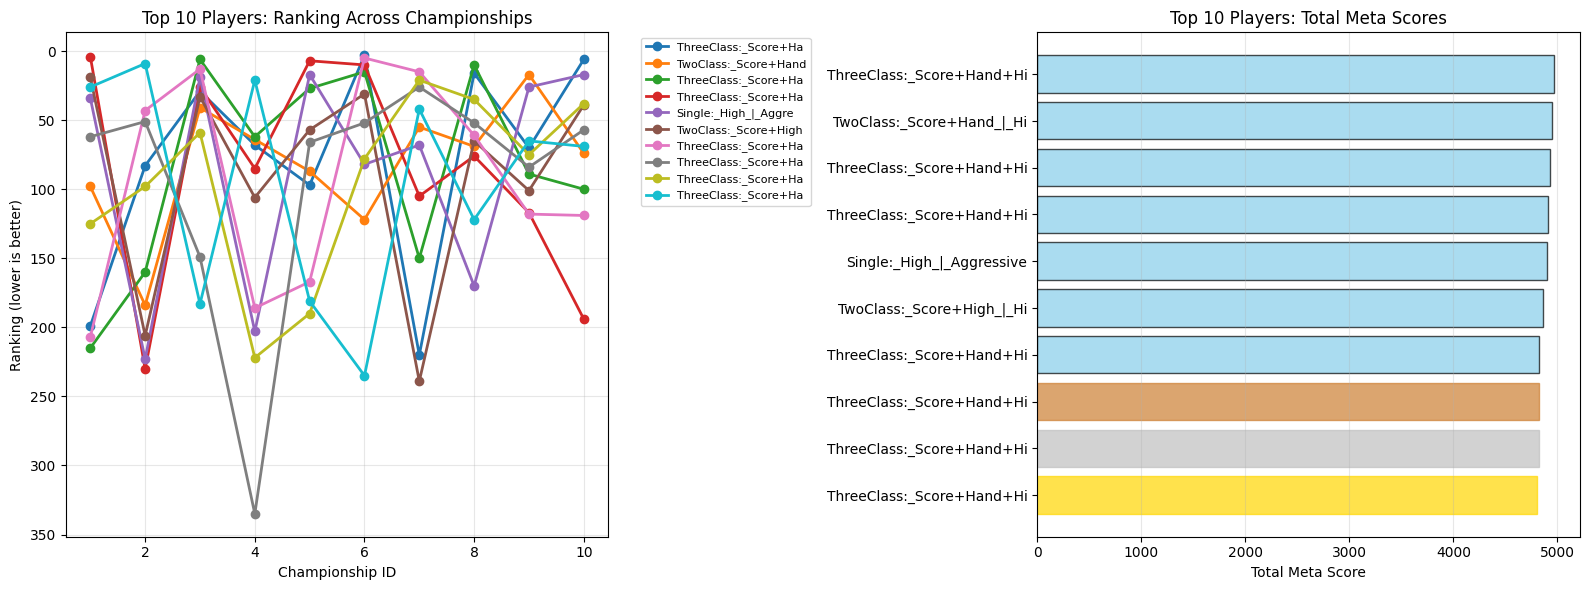

In [10]:
# Compare top 10 players across championships
top_10_names = player_stats.head(10).index.tolist()
top_10_data = df_all[df_all['name'].isin(top_10_names)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Ranking progression across championships
for name in top_10_names:
    player_data = top_10_data[top_10_data['name'] == name].sort_values('championship_id')
    short_name = name.split('_', 2)[-1][:20]
    ax1.plot(player_data['championship_id'], player_data['rank'], marker='o', label=short_name, linewidth=2)

ax1.set_xlabel('Championship ID')
ax1.set_ylabel('Ranking (lower is better)')
ax1.set_title('Top 10 Players: Ranking Across Championships')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()  # Lower rank is better

# Meta score comparison
top_10_sorted = player_stats.head(10).sort_values('meta_score_sum')
y_pos = np.arange(len(top_10_sorted))
short_names = [name.split('_', 2)[-1][:25] for name in top_10_sorted.index]

bars = ax2.barh(y_pos, top_10_sorted['meta_score_sum'], alpha=0.7, color='skyblue', edgecolor='black')
bars[0].set_color('gold')
bars[1].set_color('silver')
bars[2].set_color('#CD7F32')  # Bronze

ax2.set_yticks(y_pos)
ax2.set_yticklabels(short_names)
ax2.set_xlabel('Total Meta Score')
ax2.set_title('Top 10 Players: Total Meta Scores')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 11. Visualization: Consistency vs Performance

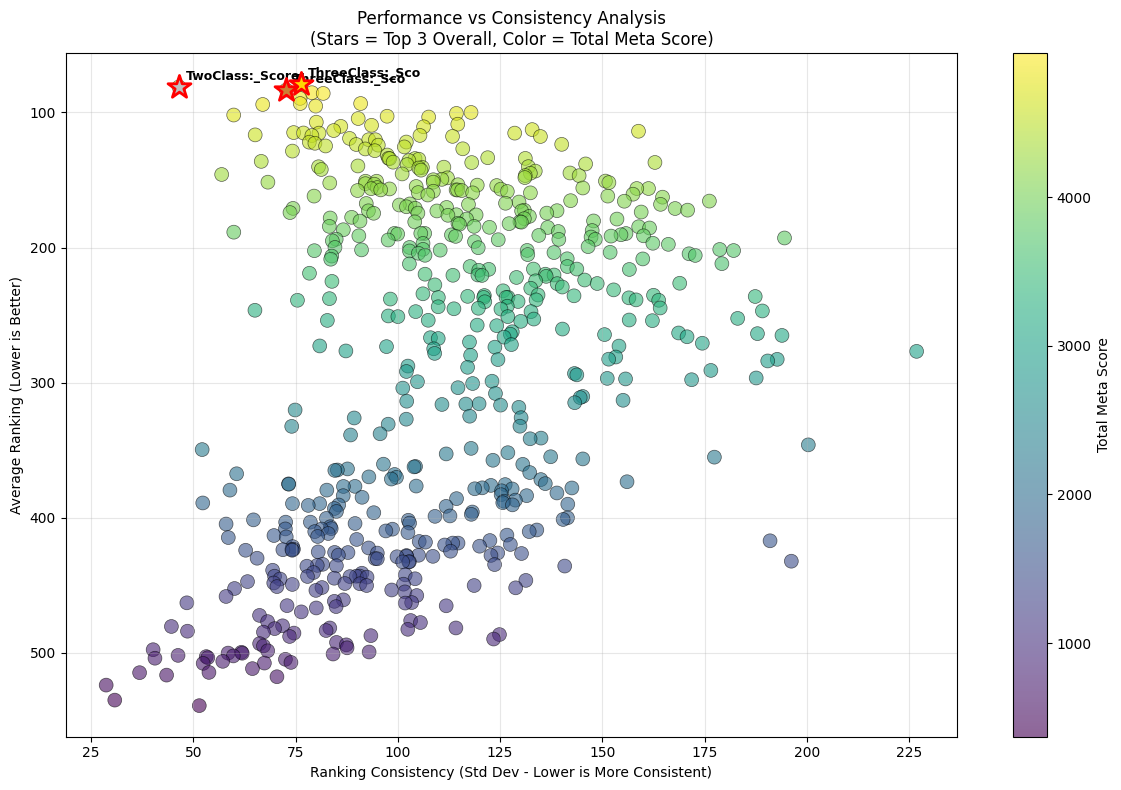

Interpretation:
  • Bottom-left corner: Consistent high performers (ideal)
  • Bottom-right corner: High performers with variable results
  • Top-left corner: Consistent average performers
  • Top-right corner: Inconsistent low performers


In [11]:
plt.figure(figsize=(12, 8))

# Scatter plot: consistency (std) vs performance (mean rank)
scatter = plt.scatter(player_stats['rank_std'], player_stats['rank_mean'], 
                     c=player_stats['meta_score_sum'], cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

# Highlight top 3 overall performers
top_3 = player_stats.head(3)
for idx, (name, stats) in enumerate(top_3.iterrows()):
    plt.scatter(stats['rank_std'], stats['rank_mean'], 
               s=300, marker='*', edgecolors='red', linewidth=2, 
               c='gold' if idx == 0 else 'silver' if idx == 1 else '#CD7F32',
               zorder=10)
    short_name = name.split('_', 2)[-1][:15]
    plt.annotate(short_name, (stats['rank_std'], stats['rank_mean']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.xlabel('Ranking Consistency (Std Dev - Lower is More Consistent)')
plt.ylabel('Average Ranking (Lower is Better)')
plt.title('Performance vs Consistency Analysis\n(Stars = Top 3 Overall, Color = Total Meta Score)')
plt.colorbar(scatter, label='Total Meta Score')
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()  # Lower rank is better

plt.tight_layout()
plt.show()

print("Interpretation:")
print("  • Bottom-left corner: Consistent high performers (ideal)")
print("  • Bottom-right corner: High performers with variable results")
print("  • Top-left corner: Consistent average performers")
print("  • Top-right corner: Inconsistent low performers")

## 12. Export Meta-Analysis Results

In [12]:
# Prepare export data
export_data = {
    'meta_analysis_info': {
        'num_championships': NUM_CHAMPIONSHIPS,
        'scoring_method': SCORING_METHOD,
        'total_players': len(player_stats),
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'championship_files': [os.path.basename(f) for f in selected_files]
    },
    'overall_rankings': player_stats.reset_index().to_dict('records'),
    'strategy_performance': strategy_performance.reset_index().to_dict('records'),
    'top_10_detailed': []
}

# Add detailed history for top 10
for name in player_stats.head(10).index:
    player_history = df_all[df_all['name'] == name][['championship_id', 'rank', 'wins', 'win_percentage', 'meta_score']].to_dict('records')
    export_data['top_10_detailed'].append({
        'name': name,
        'championship_history': player_history
    })

# Export to JSON
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_filename = f"../results/meta_analysis_{timestamp}.json"
with open(export_filename, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"💾 Meta-analysis results exported to: {export_filename}")

# Also export as CSV for easier viewing
csv_filename = f"../results/meta_analysis_{timestamp}.csv"
player_stats.reset_index().to_csv(csv_filename, index=False)
print(f"💾 CSV export: {csv_filename}")

💾 Meta-analysis results exported to: ../results/meta_analysis_20260120_153126.json
💾 CSV export: ../results/meta_analysis_20260120_153126.csv


## 13. Championship Winners Analysis

Analyze which players won individual championships and how often.

In [13]:
# Find champions of each championship
champions = df_all[df_all['rank'] == 1].sort_values('championship_id')

print("🏆 INDIVIDUAL CHAMPIONSHIP WINNERS")
print("="*60)
for _, champ in champions.iterrows():
    short_name = champ['name'].split('_', 2)[-1]
    print(f"Championship {int(champ['championship_id'])}: {short_name}")
    print(f"   Strategy: {champ['strategy']}")
    print(f"   Wins: {champ['wins']}, Win %: {champ['win_percentage']:.2f}%\n")

# Count repeat champions
champion_counts = champions['name'].value_counts()
if champion_counts.max() > 1:
    print("\n🌟 REPEAT CHAMPIONS (Won multiple championships):")
    repeat_champs = champion_counts[champion_counts > 1]
    for name, count in repeat_champs.items():
        short_name = name.split('_', 2)[-1]
        print(f"   {short_name}: {count} championship wins")
else:
    print("\n📊 No repeat champions - each championship had a different winner")

🏆 INDIVIDUAL CHAMPIONSHIP WINNERS
Championship 1: Single:_High_|_Conservative_High_Value_3
   Strategy: Single: High | Conservative High Value_3
   Wins: 10000, Win %: 100.00%

Championship 2: ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Conservative_Hand_Size_+_Moderate_High_Value_3
   Strategy: ThreeClass: Score+Hand+High | Very Aggressive Score + Conservative Hand Size + Moderate High Value_3
   Wins: 10000, Win %: 100.00%

Championship 3: TwoClass:_Hand+High_|_Very_Conservative_Hand_Size_+_Aggressive_High_Value_2
   Strategy: TwoClass: Hand+High | Very Conservative Hand Size + Aggressive High Value_2
   Wins: 10000, Win %: 100.00%

Championship 4: ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Aggressive_Hand_Size_+_Moderate_High_Value_3
   Strategy: ThreeClass: Score+Hand+High | Very Aggressive Score + Aggressive Hand Size + Moderate High Value_3
   Wins: 10000, Win %: 100.00%

Championship 5: Single:_Hand_|_Moderate_Hand_Size
   Strategy: Single: Hand | Moderate H

## 14. Final Meta-Analysis Summary

In [14]:
print("="*70)
print("🏆 FLIP 7 META-CHAMPIONSHIP FINAL SUMMARY")
print("="*70)

# Overall meta champion
meta_champion = player_stats.iloc[0]
meta_champion_name = player_stats.index[0]

print(f"\n🥇 META-CHAMPION: {meta_champion_name.split('_', 2)[-1]}")
print(f"   Strategy: {meta_champion['strategy']}")
print(f"   Total Meta Score: {meta_champion['meta_score_sum']:.1f}")
print(f"   Average Ranking: {meta_champion['rank_mean']:.1f} across {int(meta_champion['championships_played'])} championships")
print(f"   Best Ranking: #{int(meta_champion['rank_min'])}")
print(f"   Worst Ranking: #{int(meta_champion['rank_max'])}")
print(f"   Consistency Score (Lower is Better): {meta_champion['rank_std']:.2f}")
print(f"   Total Championship Wins: {int(meta_champion['wins_sum'])}")
print(f"   Average Win Rate: {meta_champion['win_percentage_mean']:.2f}%")

print(f"\n📊 Meta-Analysis Statistics:")
print(f"   Championships Analyzed: {NUM_CHAMPIONSHIPS}")
print(f"   Total Players: {len(player_stats)}")
print(f"   Total Games Played: {df_all['games_played'].sum()}")
print(f"   Scoring Method: {SCORING_METHOD}")

print(f"\n⭐ Best Strategy Type: {best_strategy}")
print(f"   Average ranking: {strategy_performance.iloc[0]['rank_mean']:.1f}")

print(f"\n📈 Performance Distribution:")
print(f"   Meta Score Range: {player_stats['meta_score_sum'].min():.1f} - {player_stats['meta_score_sum'].max():.1f}")
print(f"   Average Ranking Range: {player_stats['rank_mean'].min():.1f} - {player_stats['rank_mean'].max():.1f}")

print(f"\n💾 Results exported to: {export_filename}")
print(f"📅 Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n" + "="*70)
print("🎉 Meta-Analysis Complete!")
print("="*70)

🏆 FLIP 7 META-CHAMPIONSHIP FINAL SUMMARY

🥇 META-CHAMPION: ThreeClass:_Score+Hand+High_|_Very_Aggressive_Score_+_Moderate_Hand_Size_+_Moderate_High_Value_3
   Strategy: ThreeClass: Score+Hand+High | Very Aggressive Score + Moderate Hand Size + Moderate High Value_3
   Total Meta Score: 4969.0
   Average Ranking: 79.1 across 10 championships
   Best Ranking: #3
   Worst Ranking: #220
   Consistency Score (Lower is Better): 76.30
   Total Championship Wins: 69166
   Average Win Rate: 69.17%

📊 Meta-Analysis Statistics:
   Championships Analyzed: 10
   Total Players: 575
   Total Games Played: 57500000
   Scoring Method: inverse

⭐ Best Strategy Type: ThreeClass: Score+Hand+High | Very Aggressive Score + Moderate Hand Size + Moderate High Value_3
   Average ranking: 79.1

📈 Performance Distribution:
   Meta Score Range: 370.0 - 4969.0
   Average Ranking Range: 79.1 - 539.0

💾 Results exported to: ../results/meta_analysis_20260120_153126.json
📅 Analysis completed: 2026-01-20 15:31:26

🎉 Me